In [1]:

%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import os
print(os.getpid())
%cd ../../

import pylib.mix as mix
import pylib.measurement as mse
import kvn

colors_ = ["blue", "red", "green", "gray", "black"]

14309
/media/work/docs/codes/QuCF/scripts-py


In [2]:
for i in range(30):
    plt.close()

Work directory: ../QuCF/simulations/LCHS/TEST-2/kmax-10
--- Strong non-Hermiticity ---

Reference computation

--- refence computation ---
sum psi[RK-max-time]**2: 2.174e-02
Done

LCHS-python computation
Done.


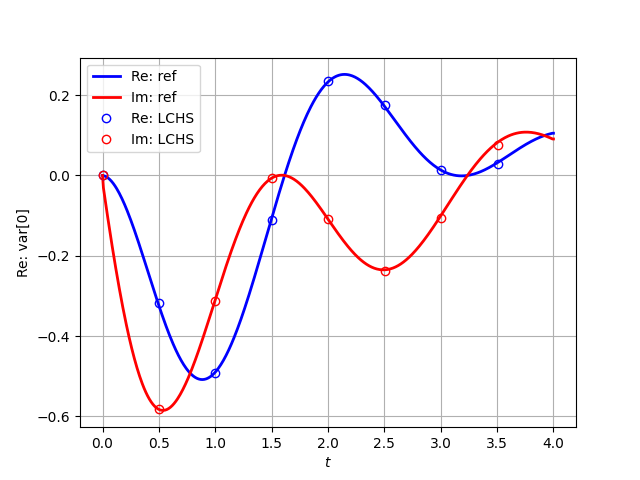

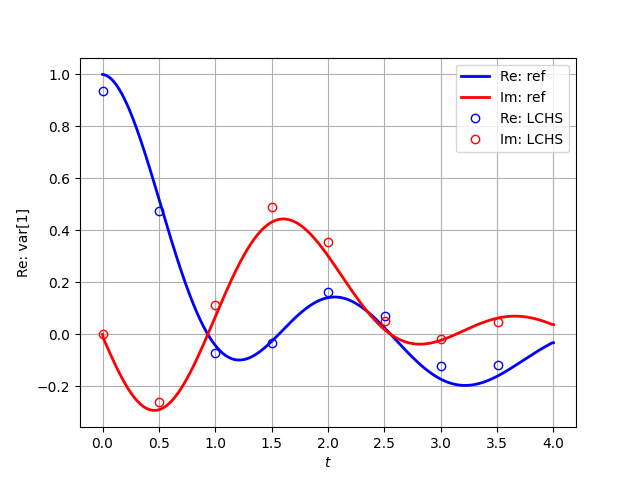

max. abs. err: 6.361e-02


In [4]:
# ---------------------------------------------------
# --- Grid's parameters ---
# ---------------------------------------------------
mix.reload_module(kvn)

# Choose the case for modeling:
sel_case_ = 2

# for correcting a global phase:
str_case_ = ""
if sel_case_ == 1:
    coef_sign_ = 1
    str_case_ = "WD: O_w"
if sel_case_ == 2:
    coef_sign_ = -1
    str_case_ = "SD: O_w"

if sel_case_ == 10:
    coef_sign_ = 1
    str_case_ = "WD: O_sqrt_w"
if sel_case_ == 20:
    coef_sign_ = 1
    str_case_ = "SD: O_srt_w"

if sel_case_ == 100:
    coef_sign_ = 1
    str_case_ = "WD: O_sqrt_w"
if sel_case_ == 200:
    coef_sign_ = 1
    str_case_ = "SD: O_srt_w"

# --- system parameters ---
nt_          = 9
t_max_       = 4
diff_nt_plot = 6

nk_, k_max_  = 5, 10
# nk_, k_max_  = 8, 100

# --- work paths ---
path_save_ = "./jupyter-notebooks/NL/results/"
path_qucf_ = "../QuCF/simulations/LCHS/TEST-{:d}/kmax-{:d}".format(sel_case_, int(k_max_))
if sel_case_ == 3 or sel_case_ == 4:
    path_qucf_ = "../QuCF/simulations/LCHS/TEST-{:d}".format(sel_case_)
if sel_case_ >= 100:
    path_qucf_ = "../QuCF/simulations/LCHS/TEST-{:d}/kmax-{:d}-AA".format(sel_case_//10, int(k_max_))
print("Work directory: {:s}".format(path_qucf_))

# non-normalized time step to produce the trotterization in the LCHS circuit: 
t_step_ = 0.1
if (sel_case_ == 2 or sel_case_ == 20) and k_max_ == 100:
    t_step_ = t_step_ / 10.

# time grid:
Nt_    = 1 << nt_
t_     = np.linspace(0, t_max_, Nt_)
dt_    = np.diff(t_)[0]

diff_N_ = 1 << diff_nt_plot
N_plot  = 1 << (nt_ - diff_nt_plot)

t_plot_ = np.zeros(N_plot)
for it in range(N_plot):
    t_plot_[it] = it * diff_N_ * dt_
del it

# k-grid for the LCHS:
Nk_    = 1 << nk_
k_     = np.linspace(-k_max_, k_max_, Nk_)
dk_    = np.diff(k_)[0]

# initial state:
psi_init_ = kvn.get_initial_state()

# choose the matrix:
Hi_ = kvn.get_case_Hi(sel_case_)

# ------------------------------------------------------------------
# --- Reference computation ---
print()
print("Reference computation")
psi_ref_ = kvn.ref_computation(t_, Hi_, psi_init_)
print("Done")

# ------------------------------------------------------------------
# --- LCHS-python simulation ---
print()
print("LCHS-python computation")
psi_LCHS_py = np.zeros((N_plot, 2), dtype = complex)
for it in range(N_plot):
    id_t = it * diff_N_  
    psi_LCHS_py[it,:] = kvn.LCHS_computation(
        k_, dt_,
        Hi_, psi_init_, id_t, 
        flag_trotterization = True, 
        flag_print = False
    )
del id_t, it
print("Done.")

# ------------------------------------------------------------------
# --- Compare the reference and the LCHS-python computations ---
kvn.compare_plots_ref_LCHS_py(t_, t_plot_, psi_ref_, psi_LCHS_py, id_var = 0)
kvn.compare_plots_ref_LCHS_py(t_, t_plot_, psi_ref_, psi_LCHS_py, id_var = 1)

max_abs_err = 0
for it in range(len(t_plot_)):
    err = np.max(np.abs(psi_ref_[it * diff_N_] - psi_LCHS_py[it]))
    if max_abs_err < err:
        max_abs_err = err
print("max. abs. err: {:0.3e}".format(max_abs_err))
del max_abs_err, err , it

In [5]:
# ---------------------------------------------------------------------------------------
# --- Parameters for the block encoding ---
# ---------------------------------------------------------------------------------------
mix.reload_module(mix)
mix.reload_module(kvn)

def compute_angles_2x2(A_norm, nonsparsity, str_A):
    ay_00, az_00 = mix.calc_angles_from_a_value(A_norm[0,0] * nonsparsity)
    ay_01, az_01 = mix.calc_angles_from_a_value(A_norm[0,1] * nonsparsity)
    ay_10, az_10 = mix.calc_angles_from_a_value(A_norm[1,0] * nonsparsity)
    ay_11, az_11 = mix.calc_angles_from_a_value(A_norm[1,1] * nonsparsity)
  
    print("ay_00_{:s}  {:0.12e}".format(str_A, ay_00))
    if az_00 is not None:
        print("az_00_{:s}  {:0.12e}".format(str_A, az_00))

    print("ay_01_{:s}  {:0.12e}".format(str_A, ay_01))
    if az_01 is not None:
        print("az_01_{:s}  {:0.12e}".format(str_A, az_01))

    print("ay_10_{:s}  {:0.12e}".format(str_A, ay_10))
    if az_10 is not None:
        print("az_10_{:s}  {:0.12e}".format(str_A, az_10))

    print("ay_11_{:s}  {:0.12e}".format(str_A, ay_11))
    if az_11 is not None:
        print("az_11_{:s}  {:0.12e}".format(str_A, az_11))
    return


# --------------------------------------------------------------------------------------------    
    
# --- Find Hermitian and anti-Hermitian parts of the system ---
Ah, Aa = mix.get_herm_aherm_parts(Hi_)

print("\n*** Hermitian part of i*H (Ah) ***")
mix.print_matrix(Ah)

print("\n*** Anti-Hermitian part of i*H (Aa) ***")
mix.print_matrix(Aa)

Ba     = Aa 
B_kmax = - k_max_ * Ah
Bk     =      dk_ * Ah

# --- Normalize the hermitian and anti-Hermitian parts of the matrix ---
Ba_norm,     ncoef_a,    nonsparsity_a    = mix.compute_normalized_matrix(Ba, "Ba")
B_kmax_norm, ncoef_kmax, nonsparsity_kmax = mix.compute_normalized_matrix(B_kmax, "B_kmax")
Bk_norm,     ncoef_k,    nonsparsity_k    = mix.compute_normalized_matrix(Bk, "Bk")

print("\n*** Normalized Aa ***")
mix.print_matrix(Ba_norm, ff=[25, 3, "e"])

print("\n*** Normalized ( - kmax*Ah) ***")
mix.print_matrix(B_kmax_norm, ff=[25, 3, "e"])

print("\n*** Normalized dk*Ah ***")
mix.print_matrix(Bk_norm, ff=[25, 3, "e"])

# Print initial state:
print("\n*** Initial state ***")
mix.print_array(psi_init_, ff=[25, 3, "e"])

# --- The number of qubits for encoding variables ---
print("\n\n\n***************************************************************")
print("***************************************************************")
print("\n//--- For data ---")
print("nx \t{:d}".format(1))

# --- Compute angles for the herm. and a-herm. matrices ---
print("\n//--- The angles for the BE oracles ---")
if nonsparsity_a > 0:
    compute_angles_2x2(Ba_norm,     nonsparsity_a,    "a")
if nonsparsity_kmax > 0:
    compute_angles_2x2(B_kmax_norm, nonsparsity_kmax, "kmax")
if nonsparsity_k > 0:
    compute_angles_2x2(Bk_norm,     nonsparsity_k,    "k")

# --- Compute angles for the initialization circuit ---
print("\n//--- The angles for the initialization ---")
kvn.compute_angles_initialization(psi_init_)

# --- Compute angles for the weights ---
print("\n//--- Angles for the weight-oracle ---")
alpha_k0 = - 1.0
alpha_k1 = np.abs(alpha_k0) * Nk_/(Nk_ - 1)

print("nk \t{:d}".format(nk_))
print("alpha_k0 \t{:0.12e}".format(alpha_k0))
print("alpha_k1 \t{:0.12e}".format(alpha_k1))

# --- Time steps ---
dt_a    = ncoef_a    * t_step_ / 2.
dt_kmax = ncoef_kmax * t_step_
dt_k    = ncoef_k    * t_step_
print("\n--- Time steps ---")
print("dt_a:    {:0.6e}".format(dt_a))
print("dt_kmax: {:0.6e}".format(dt_kmax))
print("dt_k:    {:0.6e}".format(dt_k))

print()
for ik in range(nk_):
    dt_k = 2**ik * ncoef_k * t_step_
    print("dt_k{:d}: {:0.6e}".format(ik, dt_k))


*** Hermitian part of i*H (Ah) ***
--- 0 ---
 1.000+0.000j  0.000+0.000j
--- 1 ---
 0.000+0.000j  0.000+0.000j

*** Anti-Hermitian part of i*H (Aa) ***
--- 0 ---
 1.000+0.000j  2.000+0.000j
--- 1 ---
 2.000+0.000j  1.000+0.000j
Matrix Ba:	 nonsparsity, coefnorm: 2, 4.472e+00
Matrix B_kmax:	 nonsparsity, coefnorm: 1, 1.000e+01
Matrix Bk:	 nonsparsity, coefnorm: 1, 1.000e+00

*** Normalized Aa ***
--- 0 ---
     2.236e-01+0.000e+00j      4.472e-01+0.000e+00j
--- 1 ---
     4.472e-01+0.000e+00j      2.236e-01+0.000e+00j

*** Normalized ( - kmax*Ah) ***
--- 0 ---
    -1.000e+00+0.000e+00j      0.000e+00+0.000e+00j
--- 1 ---
     0.000e+00+0.000e+00j      0.000e+00+0.000e+00j

*** Normalized dk*Ah ***
--- 0 ---
     6.452e-01+0.000e+00j      0.000e+00+0.000e+00j
--- 1 ---
     0.000e+00+0.000e+00j      0.000e+00+0.000e+00j

*** Initial state ***
     0.000e+00+0.000e+00j      1.000e+00+0.000e+00j 



***************************************************************
**************************


--------------------------------------------------
--- t = 5.000 ---
--------------------------------------------------

Reading the file ../QuCF/simulations/LCHS-TEST-10/kmax-100-AA/N_5_OUTPUT.hdf5...
Name of the simulation is N_5
Simulation has been performed  04-17-2024 17:00:39
success prob: 9.922e-01

--- QSP: qsp_a ---
dt: 0.224
nt: 1.000

--- QSP: qsp_k ---
dt: 0.100
nt: 1.000

--- QSP: qsp_kmax ---
dt: 0.100
nt: 1.000
nk: 8

--------------------------------------------------
--- t = 10.000 ---
--------------------------------------------------

Reading the file ../QuCF/simulations/LCHS-TEST-10/kmax-100-AA/N_10_OUTPUT.hdf5...
Name of the simulation is N_10
Simulation has been performed  04-17-2024 17:01:09
success prob: 9.903e-01

--- QSP: qsp_a ---
dt: 0.224
nt: 1.000

--- QSP: qsp_k ---
dt: 0.100
nt: 1.000

--- QSP: qsp_kmax ---
dt: 0.100
nt: 1.000
nk: 8

--------------------------------------------------
--- t = 15.000 ---
--------------------------------------------------



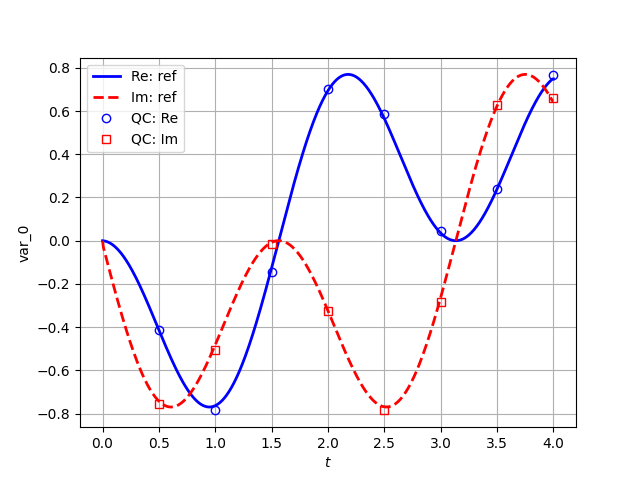

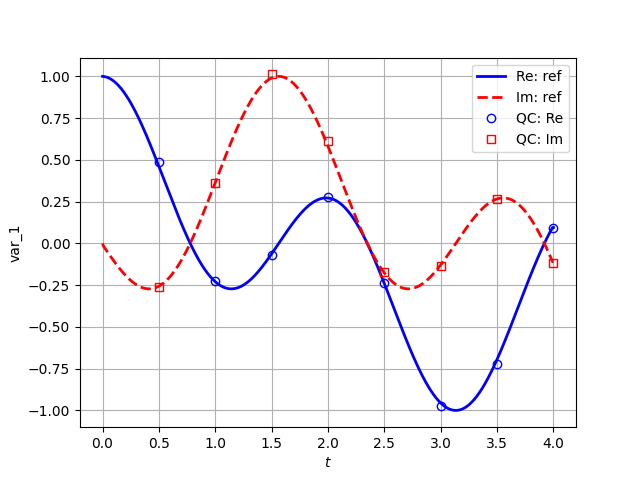

max. abs. err: 3.012e-02


In [6]:
# --------------------------------------------------------
# --- Read results from quantum simulations ---
# --------------------------------------------------------
mix.reload_module(mse)

# -------------------------------------------------
def plot_QC_vs_REF(t_ref, psi_ref, qt_points, psi_qc, id_var, flag_save):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    # --- Plotting ---
    ax.plot(t_ref, psi_ref.real[:,id_var], "-b",  linewidth = 2, label="Re: ref")
    ax.plot(t_ref, psi_ref.imag[:,id_var], "--r", linewidth = 2, label="Im: ref")
    
    ax.plot(
        qt_points, coef_sign_ * psi_qc.real[:,id_var], 
        "o", markerfacecolor='None', markeredgecolor='b', linestyle='None',
        label = "QC: Re"
    )
    ax.plot(
        qt_points, coef_sign_ * psi_qc.imag[:,id_var], 
        "s", markerfacecolor='None', markeredgecolor='r', linestyle='None',
        label = "QC: Im"
    )

    plt.xlabel('$t$')
    plt.ylabel("var_{:d}".format(id_var))
    ax.legend()
    plt.grid(True)
    plt.show()

    if flag_save:
        if sel_case_ == 1 or sel_case_ == 10:
            str_sel = "WD"
        elif sel_case_ == 2 or sel_case_ == 20:
            str_sel = "SD"
        else:
            return
        mix.save_dat_plot_1d_file(
            path_save_ + "/LCHS_test_{:s}_kmax{:d}_v{:d}_REF_RE.dat".format(str_sel, k_max_, id_var),    
            t_ref, psi_ref.real[:,id_var]
        )
        mix.save_dat_plot_1d_file(
            path_save_ + "/LCHS_test_{:s}_kmax{:d}_v{:d}_REF_IM.dat".format(str_sel, k_max_, id_var),    
            t_ref, psi_ref.imag[:,id_var]
        )
        mix.save_dat_plot_1d_file(
            path_save_ + "/LCHS_test_{:s}_kmax{:d}_v{:d}_QC_RE.dat".format(str_sel, k_max_, id_var),    
            qt_points, coef_sign_ * psi_qc.real[:,id_var]
        )
        mix.save_dat_plot_1d_file(
            path_save_ + "/LCHS_test_{:s}_kmax{:d}_v{:d}_QC_IM.dat".format(str_sel, k_max_, id_var),    
            qt_points, coef_sign_ * psi_qc.imag[:,id_var]
        )
    return
# ------------------------------------------------------------------------------
def read_data(Nt_point):
    print()  
    pro_name_work = "N_{:d}".format(Nt_point)

    # --- Read the _OUTPUT.hdf5 file ---
    om = mse.MeasOracle__()
    om.path_  = path_qucf_
    om.pname_ = pro_name_work
    om.open()
    
    # --- get the result ---
    om.set_zero_ancillae_work_states(0)
    qc_state_t = om.get_var_x({}, "rx")
    
    print("success prob: {:0.3e}".format(
        np.sum(np.abs(qc_state_t)**2)
    ))

    # parameters of the k-grid:
    om.read_qsvt()
    nk_c = om.dd_["regs"]["rk"]
    k_max_c = om.dd_["weights"]["par"]
    Nk_c = 1 << nk_c
    k_grid = np.linspace(-k_max_c, k_max_c, Nk_c)
    dk_c = np.diff(k_grid)[0]
    
    print("nk: {:d}".format(nk_c))

    # renormalization:
    Hadamart_norm_factor = 2**(nk_c) 
    coef_norm = Hadamart_norm_factor / om.dd_["weights"]["rescaling_factor"]
    qc_state_t *= coef_norm * (dk_c / np.pi)

    # --- get the time point ---
    Nt = int(om.constants_["Nt"])   
    qt_final = t_step_ * Nt  
    return qt_final, qc_state_t
# ------------------------------------------------------------------------------
flag_save = False

Nt_points = np.array([5, 10, 15, 20, 25, 30, 35, 40])

if (sel_case_ == 2 or sel_case_ == 20) and k_max_ == 100:
    Nt_points *= 10
psi_qc    = np.zeros((len(Nt_points), 2), dtype=complex)
qt_points = np.zeros(len(Nt_points))
for ii in range(len(Nt_points)):
    print("\n--------------------------------------------------")
    print("--- t = {:0.3f} ---".format(Nt_points[ii]))
    print("--------------------------------------------------")
    qt_one, psi_one = read_data(Nt_points[ii])
    qt_points[ii] = qt_one
    psi_qc[ii, :] = psi_one  

# --- Plotting ---
psi_ref_norm = np.array(psi_ref_)
psi_qc_norm  = np.array(psi_qc)

# --- For the cases with amplified weights ---
if sel_case_ >= 100:
    # ************************************************************************
    # These amplification signals are computed in calc-weights.ipynb 
    # by comparing non-amplified and amplified sqrt(weights) 
    # ************************************************************************
    if k_max_ == 10 and nk_ == 5:
        rr = 2.470306404836081
    if k_max_ == 100 and nk_ == 8:
        rr = 7.925308465279e+00
    psi_qc_norm /= rr**2


plot_QC_vs_REF(t_, psi_ref_norm, qt_points, psi_qc_norm, id_var = 0, flag_save = flag_save)
plot_QC_vs_REF(t_, psi_ref_norm, qt_points, psi_qc_norm, id_var = 1, flag_save = flag_save)

# --- Compute the error ---
max_abs_err = 0
for id_var in range(2):
    for it in range(len(Nt_points)):
        t1 = qt_points[it]
        v_ref = np.interp(t1, t_, psi_ref_norm[:, id_var])  
        err = np.max(np.abs(v_ref - coef_sign_ * psi_qc_norm[it, id_var]))
        if max_abs_err < err:
            max_abs_err = err
print("max. abs. err: {:0.3e}".format(max_abs_err))

del flag_save

In [25]:
# ---------------------------------------------------------
# --- Read data for scans ---
# ---------------------------------------------------------
mix.reload_module(mse)

# ------------------------------------------------------------------------------
def read_data_for_scan(Nt_point):
    print()  
    pro_name_work = "N_{:d}".format(Nt_point)

    # --- Read the _OUTPUT.hdf5 file ---
    om = mse.MeasOracle__(flag_print = False)
    om.path_  = path_qucf_
    om.pname_ = pro_name_work
    om.open()
    
    # --- get the result ---
    om.set_zero_ancillae_work_states(0)
    qc_state_t = om.get_var_x({}, "rx")
    succ_prob = np.sum(np.abs(qc_state_t)**2)

    # parameters of the k-grid:
    om.read_qsvt()
    nk_c = om.dd_["regs"]["rk"]
    k_max_c = om.dd_["weights"]["par"]
    Nk_c = 1 << nk_c
    k_grid = np.linspace(-k_max_c, k_max_c, Nk_c)
    dk_c = np.diff(k_grid)[0]
    print("nk, kmax: {:d}, {:0.3f},".format(nk_c, k_max_c))

    # --- get the time point ---
    Nt = int(om.constants_["Nt"])   
    qt_final = t_step_ * Nt  

    # --- Printing results ---
    print(
        "t, succ_prob, Ngates: {:0.2f}, {:0.6e}, {:d}".format
        (
            qt_final, succ_prob, om.dd_["N-gates"]
        )
    )
    return
# ------------------------------------------------------------------------------

print("-----------------------------------------------")
print("--- {:s}: kmax = {:d} ---".format(str_case_, k_max_))
print("-----------------------------------------------")
for ii in range(len(Nt_points)):
    print()
    read_data_for_scan(Nt_points[ii]) 

-----------------------------------------------
--- WD: O_w: kmax = 100 ---
-----------------------------------------------


nk, kmax: 8, 100.000,
t, succ_prob, Ngates: 0.50, 2.413501e-04, 259846


nk, kmax: 8, 100.000,
t, succ_prob, Ngates: 1.00, 2.413500e-04, 506696


nk, kmax: 8, 100.000,
t, succ_prob, Ngates: 1.50, 2.413500e-04, 753546


nk, kmax: 8, 100.000,
t, succ_prob, Ngates: 2.00, 2.413500e-04, 1000396


nk, kmax: 8, 100.000,
t, succ_prob, Ngates: 2.50, 2.413498e-04, 1247246


nk, kmax: 8, 100.000,
t, succ_prob, Ngates: 3.00, 2.413497e-04, 1494096


nk, kmax: 8, 100.000,
t, succ_prob, Ngates: 3.50, 2.413497e-04, 1740946


nk, kmax: 8, 100.000,
t, succ_prob, Ngates: 4.00, 2.413495e-04, 1987796


In [5]:
# ---------------------------------------------------------
# --- Scans ---
# ---------------------------------------------------------
def scans_time():
    def save_data(str_data, str_sel, kmax, x_data, y_data):
        mix.save_dat_plot_1d_file(
            path_save_ + "/scan_LCHS_test_{:s}_kmax{:d}_time_{:s}.dat".format(str_sel, kmax, str_data),    
            x_data, y_data
        )
        return
    # -----------------------------------
    t_array = np.array([0.50, 1.00, 1.50, 2.00, 2.50, 3.00, 3.50, 4.00])

    # --- WD: kmax = 10 ---
    print()
    kmax, nk, str_sel = 10, 5, "wD"
    ssp = [2.039194e-02] * len(t_array)
    Ngs = [34873., 69703., 104533., 139363., 174193., 209023., 243853., 278683.]
    save_data("ssp", str_sel, kmax, np.log10(np.array(t_array)), np.log10(np.array(ssp)))
    save_data("Ng",  str_sel, kmax, np.log10(np.array(t_array)), np.log10(np.array(Ngs)))

    # --- SD: kmax = 10 ---
    print()
    kmax, nk, str_sel = 10, 5, "sD"
    ssp = [
        1.706924e-02, 8.249619e-03, 5.740603e-03, 5.030771e-03, 
        2.203922e-03, 6.444161e-04, 5.583099e-04, 4.228274e-04
    ]
    Ngs = [36946., 72896., 108846., 144796., 180746., 216696., 252646., 288596.]
    save_data("ssp", str_sel, kmax, np.log10(np.array(t_array)), np.log10(np.array(ssp)))
    save_data("Ng",  str_sel, kmax, np.log10(np.array(t_array)), np.log10(np.array(Ngs)))

    # --- WD: kmax = 100 ---
    print()
    kmax, nk, str_sel = 100, 8, "wD"
    ssp = [2.413501e-04] * len(t_array)
    Ngs = [259846., 506696., 753546., 1000396., 1247246., 1494096., 1740946., 1987796.]
    save_data("ssp", str_sel, kmax, np.log10(np.array(t_array)), np.log10(np.array(ssp)))
    save_data("Ng",  str_sel, kmax, np.log10(np.array(t_array)), np.log10(np.array(Ngs)))

    # --- SD: kmax = 100 ---
    print()
    kmax, nk, str_sel = 100, 8, "sD"
    ssp = [
        1.955189e-04, 8.497992e-05, 4.970357e-05, 4.444676e-05,
        2.135918e-05, 9.293143e-06, 8.526555e-06, 5.021077e-06
    ]
    Ngs = [1804696., 3596396., 5388096., 7179796., 8971496., 10763196., 12554896., 14346596.]
    save_data("ssp", str_sel, kmax, np.log10(np.array(t_array)), np.log10(np.array(ssp)))
    save_data("Ng",  str_sel, kmax, np.log10(np.array(t_array)), np.log10(np.array(Ngs)))

    return
# ---------------------------------------------------------------
scans_time()


write data to a file: ./jupyter-notebooks/NL/results//scan_LCHS_test_wD_kmax10_time_ssp.dat
write data to a file: ./jupyter-notebooks/NL/results//scan_LCHS_test_wD_kmax10_time_Ng.dat

write data to a file: ./jupyter-notebooks/NL/results//scan_LCHS_test_sD_kmax10_time_ssp.dat
write data to a file: ./jupyter-notebooks/NL/results//scan_LCHS_test_sD_kmax10_time_Ng.dat

write data to a file: ./jupyter-notebooks/NL/results//scan_LCHS_test_wD_kmax100_time_ssp.dat
write data to a file: ./jupyter-notebooks/NL/results//scan_LCHS_test_wD_kmax100_time_Ng.dat

write data to a file: ./jupyter-notebooks/NL/results//scan_LCHS_test_sD_kmax100_time_ssp.dat
write data to a file: ./jupyter-notebooks/NL/results//scan_LCHS_test_sD_kmax100_time_Ng.dat
